# CSD y CM de Actividad Evocada. 
Usemos esto como opurtunidad para poner todo el código en orden.


En este *notebook* de Julia implementaremos métodos numéricos para llevar a cabo un análisis de *centro de masa* (promedio vectorial) de la densidad de pozos y fuentes de corriente sobre una rebanada del hipocámpo de una rata. En este Notebook estudiaremos los datos de los experimentos evocados que hizo Franco en Agosto.
 Al parecer primero toca hacer una prueba con todo aquí mismo antes que hacer un modulo ordenado por una inconveniencia al hacer modulos (no se pueden recargar).

In [1]:
using HDF5

In [2]:
function AbreyCheca(x::AbstractString)
    #Abre el archivo de brw (acepta el nombre tal cual)
    archivo=h5open(x)
    #sacatito todas las variables que te interesan
    numcuadros=archivo["/3BRecInfo/3BRecVars/NRecFrames"][1][1]
    frecuencia=archivo["/3BRecInfo/3BRecVars/SamplingRate"][1][1]
    maxvolt=archivo["/3BRecInfo/3BRecVars/MaxVolt"][1][1]
    minvolt=archivo["/3BRecInfo/3BRecVars/MinVolt"][1][1]
    bitdepth=archivo["/3BRecInfo/3BRecVars/BitDepth"][1][1]
    duracionexperimento=numcuadros/frecuencia
    factordeescala=(maxvolt-minvolt)/2^bitdepth
    DatosCrudos=read(archivo["/3BData/Raw"])
    result=Dict("numcuadros" => numcuadros,
                "frecuencia"=> frecuencia,
                "maxvolt" => maxvolt,
                "minvolt" => minvolt,
                "bitdepth" => bitdepth,
                "duracion" => duracionexperimento,
                "factor " => factordeescala,
                "DatosCrudos"=>DatosCrudos )
    return result
                    
end

AbreyCheca (generic function with 1 method)

In [3]:
Datos=AbreyCheca("050815_1R4.brw")

Dict{ASCIIString,Any} with 8 entries:
  "minvolt"     => -4125.0
  "maxvolt"     => 4125.0
  "factor "     => 2.01416015625
  "frecuencia"  => 7020.800706028248
  "DatosCrudos" => 4096x210624 Array{UInt16,2}:…
  "bitdepth"    => 0x0c
  "numcuadros"  => 210624
  "duracion"    => 29.99999698312937

In [4]:
function EncuentraTrancazosRaw(datos::Array, tolerancia=1400)
    result=Int[]
    longitud=length(datos)
    jcomp=0
    for j=1:longitud
        if abs(datos[j])>tolerancia
            if j-jcomp>1
                push!(result,j)
            end
            jcomp=j
        end
    end
    return result
end


EncuentraTrancazosRaw (generic function with 2 methods)

In [5]:
exemplo=vec(Datos["DatosCrudos"][2000,:]);

In [6]:
listongas=EncuentraTrancazosRaw(exemplo)

3-element Array{Int64,1}:
  43890
 114498
 185107

In [7]:
function ActivAlrededorTrancazo(Lista::Array, xxs::Array)
    #Aqui no se le ha hecho reshape a las matrices todavia
    result=Dict{AbstractString, Array}()
    q=1
    desde=20
    hasta=480
    for j in Lista
        nomineclave="Trancazo_$q"
        result[nomineclave]=xxs[:,j-desde:j+hasta]
        #println(nomineclave)
        q+=1
    end
    return result
end

function ActividadFueraTrancazo(Lista::Array, xxs::Array)
    q=1
    desde=20
    hasta=480
    aux=trues(xxs)
    for j in Lista
        aux[j-desde:j+hasta]=false
    end
    result=zeros(1)
    aux2=find(aux)
    for j in aux2
        result=vcat(result,xxs[j])
    end
    return result
end
        
    



ActividadFueraTrancazo (generic function with 1 method)

In [8]:
ActividadRaw=ActivAlrededorTrancazo(listongas, Datos["DatosCrudos"])

Dict{AbstractString,Array{T,N}} with 3 entries:
  "Trancazo_2" => 4096x501 Array{UInt16,2}:…
  "Trancazo_1" => 4096x501 Array{UInt16,2}:…
  "Trancazo_3" => 4096x501 Array{UInt16,2}:…

In [9]:
FueraTrancazo=ActividadFueraTrancazo(listongas,exemplo);
FueraTrancazo=round(Int32,FueraTrancazo)*(-1)+2048

209122-element Array{Int32,1}:
 2048
   -2
    5
   -2
   -1
   -7
   11
    1
   25
   -8
    4
    3
   -5
    ⋮
  -13
    2
    6
   -4
  -37
   15
    3
    3
    3
    6
  -11
   -2

In [10]:
function FormaMatrizDatosCentrados(xxs::Array)
    #El array tiene que ser de 4096 por algo mas
    irrrelevante,largo=size(xxs)
    aux=Array(Int32, 64,64, largo);
    for j=1:64,k=1:64
        aux[k,j,:]=xxs[j+(k-1)*64,:]
    end
    result=round(Int32,aux)*(-1)+2048;
    aux=0
    return result
end

FormaMatrizDatosCentrados (generic function with 1 method)


Hay un montonal de canales que por la forma en que requiere ser hecho el experimento no detectaron nada o casi nada. Esos aparecen el registro como saturados en el máximo valor posible. Dado que esto es MUY inconveniente para el cálculo del CM, tenemos que detectarlos automáticamente y ponerlos en cero o ver si los esquivamos.

In [11]:
DatosCentrados=Dict{AbstractString, Array}()
for k in keys(ActividadRaw)
    DatosCentrados[k]=FormaMatrizDatosCentrados(ActividadRaw[k])
end

In [12]:
function BuscaSaturados(datos::Array, saturavalue=1700)
    (ancho,alto,largo)=size(datos)
    result=Set{Array{Int,1}}()
    arreglostd=zeros(ancho,alto)
    arregloprom=zeros(ancho,alto)
    for j=1:ancho, k=1:alto
        prom=mean(datos[k,j,:])
        arregloprom[k,j]=prom
        desviacion=std(datos[k,j,:])
        arreglostd[k,j]=desviacion
        if abs(prom)>saturavalue || desviacion<10
            push!(result, [k,j])
        end
    end
    return (result,arreglostd, arregloprom)
end

BuscaSaturados (generic function with 2 methods)

In [13]:
DictSaturados=Dict{AbstractString, Tuple}()
for k in keys(DatosCentrados)
    DictSaturados[k]=BuscaSaturados(DatosCentrados[k])
end

In [14]:
function imitaruido(x::Array)
    #Esta funcion asume que x es ruido gaussiano y lo imita.
    #Igual de largo que xx
    sigma=std(x)
    prom=mean(x)
    l=length(x)
    result=sigma*randn(l)+prom
    return result
end

function hazruido(sigma, prom, length)
    # hace ruido
    result=round(Int32, sigma*randn(length)+prom)
    return result
end



hazruido (generic function with 1 method)

In [15]:
HistogramaRuido=hist(FueraTrancazo, -100:1:100)

(-100:1:100,[0,0,0,0,0,0,0,0,0,0  …  0,0,0,0,0,0,0,0,0,0])

In [16]:
sigmaruido=std(FueraTrancazo)
promruido=mean(FueraTrancazo)
(promruido,sigmaruido)

(-0.2902755329424929,14.409291834298928)

In [17]:
RuidoArtificial=imitaruido(FueraTrancazo)
HistoRuidoArtificial=hist(RuidoArtificial,-100:1:100)
mean(RuidoArtificial),std(RuidoArtificial)

(-0.2797037323791043,14.40698586606932)

In [18]:
using PyPlot
ion()

In [19]:
mu=promruido
sigma=sigmaruido
function gauss(x)
    return 1/(sqrt(2*pi)*sigma)*exp(-((x-mu)/sigma)^2/2)
end

gauss (generic function with 1 method)

In [20]:
xdata=collect(HistogramaRuido[1][2:end])
measuredata=HistogramaRuido[2];

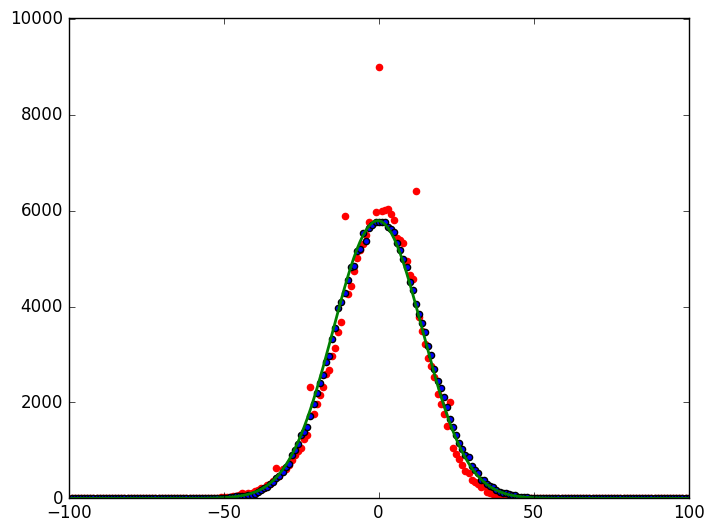

In [31]:
figure(figsize=(8,6))
xlim(-100,100)
ylim(-1,10005)
scatter(xdata,measuredata, color="red")
scatter(HistoRuidoArtificial[1][2:end],HistoRuidoArtificial[2])
plot(xdata, map(x->209122*gauss(x),xdata), color="green",lw=2)
savefig("GaussianasBonitas01.svg", dpi=96)

In [22]:
DatosDesaturados=Dict{AbstractString, Array}()
n=0

for k in keys(DatosCentrados)
    largo=length(DatosCentrados[k][1,1,:])
    lista=DictSaturados[k][1]
    aux=copy(DatosCentrados[k])
   # println(k," ",length(lista))
    
     for m in lista
        q=m[1]
        p=m[2]
        aux[q,p,:]=hazruido(sigmaruido,promruido,largo)
        n+=1
     end
    DatosDesaturados[k]=aux
end
print(n)

609

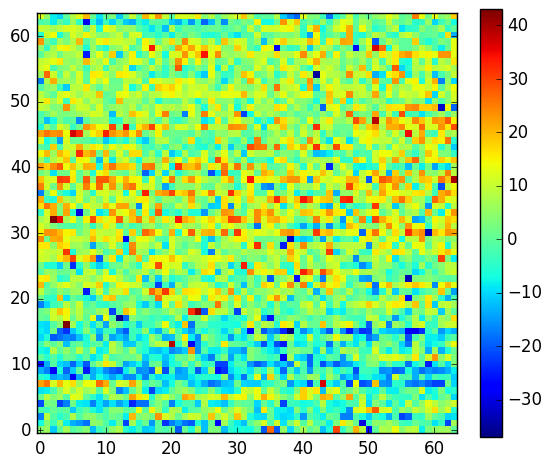

In [83]:
ion()
figure(figsize=(6,6))
exdesaturado=DatosDesaturados["Trancazo_1"][:,:,340];
imagen=imshow(exdesaturado, origin="lower", interpolation="nearest", cmap="jet")
cb=colorbar(imagen, fraction=0.046)
savefig("LFP_Desaturado_1-340.svg", dpi=96)

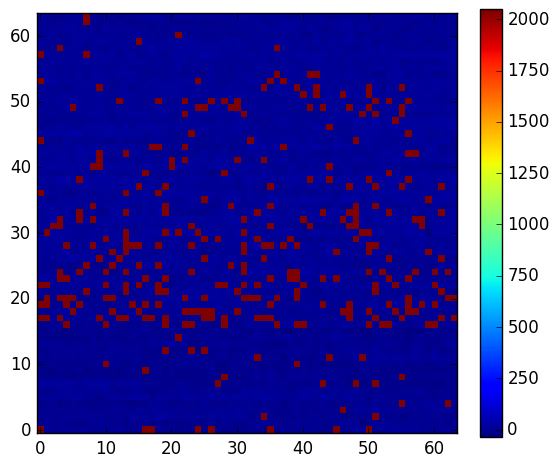

In [49]:
figure(figsize=(6,6))
exsaturado=DatosCentrados["Trancazo_1"][:,:,340];
imagen=imshow(exsaturado, origin="lower", interpolation="nearest", cmap="jet")
cb=colorbar(imagen,fraction=0.046)
savefig("LFP_Saturado_1-340.svg", dpi=96)

In [50]:
PyPlot.ioff()
for t=1:501
    exdesaturado=DatosDesaturados["Trancazo_1"][:,:,t];
    figure(figsize=(6,6))
    imagen=imshow(exdesaturado, origin="lower", interpolation="nearest", vmin=-40,vmax=40, cmap="jet")
    cb=colorbar(imagen, fraction=0.046)
    savefig("LFP_Desaturado_1-$t.png", dpi=96)
    close()
end

In [106]:
function UnNormGauss(x,sigma)
    return exp(-x*x/(2*sigma))
end

function GaussSuavizarTemporal(Datos,Sigma=3)  
    #sigma esta medido en pixeles, es la desviacion estandar de nuestro kernel.
    #El medioancho de nuestra ventana seran 3*sigma
    #Esto es escencialmente un filtro pasabajos
    medioancho=ceil(Sigma*3)
    colchon=ones(medioancho)
    result=zeros(Datos)
    datoscolchon=vcat(colchon*Datos[1], Datos, colchon*Datos[end])
    kernel=map(x->UnNormGauss(x,Sigma), collect(-medioancho:medioancho))
    kernel=kernel/(sum(kernel))
    #La convolucion asi normalizada preserva el valor RELATIVO entre los puntos de la funcion.
    #pero queremos ponerlo mas parecido a los voltajes que medimos, para preservar el rango de valores
    #experimentales y su criterio de potenciales de accion / ruido
    for t=medioancho+1:length(Datos)-medioancho
        result[t-medioancho]=sum(datoscolchon[t-medioancho:t+medioancho].*kernel)
    end
    a=maximum(abs(Datos))
    b=maximum(abs(result))
    #nromalizacion 
    #result=result*a/b
    return result
end
    

GaussSuavizarTemporal (generic function with 2 methods)

In [107]:
ela=rand(200)
ula=rand(10)
bula=rand(3)
mama=vcat(bula[1],ela,ula[2])
GaussSuavizarTemporal(ela)

200-element Array{Float64,1}:
 0.516573
 0.449564
 0.401094
 0.393379
 0.428748
 0.490565
 0.551057
 0.581412
 0.567375
 0.523293
 0.482224
 0.466085
 0.472446
 ⋮       
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     
 0.0     

In [52]:
#De momento todo "in file"
GaussianKernel=[0.00000067	0.00002292	0.00019117	0.00038771	0.00019117	0.00002292	0.00000067
0.00002292	0.00078634	0.00655965	0.01330373	0.00655965	0.00078633	0.00002292
0.00019117	0.00655965	0.05472157	0.11098164	0.05472157	0.00655965	0.00019117
0.00038771	0.01330373	0.11098164	0.22508352	0.11098164	0.01330373	0.00038771
0.00019117	0.00655965	0.05472157	0.11098164	0.05472157	0.00655965	0.00019117
0.00002292	0.00078633	0.00655965	0.01330373	0.00655965	0.00078633	0.00002292
    0.00000067	0.00002292	0.00019117	0.00038771	0.00019117	0.00002292	0.00000067]

function GaussianSmooth(Datos)
    tamanodatos=size(Datos)
    result=zeros(Datos)
    temp=copy(Datos)
    #Primero, hacemos el padding de los datos para que no se suavice demasiado
    for j=1:3
        temp=vcat(temp[1,:], temp, temp[end,:])
    end
    for j=1:3
        temp=hcat(temp[:,1], temp, temp[:,1])
    end
    
    for j=4:tamanodatos[1]+3, k=4:tamanodatos[2]+3
        #los indices van primero, "renglones", luego "columnas", etc
        aux=temp[j-3:j+3,k-3:k+3]
        result[j-3,k-3]=sum(GaussianKernel.*aux)
    end
    #Esta convolución no respeta norma L2
    #result=result*maximum(abs(Datos))/maximum(abs(result))
    return result
end



GaussianSmooth (generic function with 1 method)

In [54]:
#checa que Julia va ordenando los datos renglon por renglon, no columna por columna
LaplacianTerm1=[[0 1 0]; [1 -4 1]; [0 1 0]]
LaplacianTerm2=[[0.5 0 0.5]; [0 -2 0]; [0.5 0 0.5]]
LaplacianKernel=(1-1/3)*LaplacianTerm1+(1/3)*LaplacianTerm2

#Nueva variante: AHORA SI VAMOS A ELIMINAR LAS ORILLAS
#Los efectos de borde estan dando puro choro en el CSD.
function DiscreteLaplacian(Datos)
    result=zeros(Datos)
    temp=copy(Datos)
    #Primero, hacemos el padding de los datos para que no se suavice demasiado
    temp=vcat(temp[1,:], temp, temp[end,:])
    temp=hcat(temp[:,1], temp, temp[:,end])
    largo,ancho=size(Datos)
    aux=Array(Float64,(3,3))
    result=zeros(Datos)
    for j=2:largo+1, k=2:ancho+1
        #los indices van primero, "renglones", luego "columnas", etc
        aux=temp[j-1:j+1,k-1:k+1]
        result[j-1,k-1]=sum(LaplacianKernel.*aux)
    end
    #Crop the borders
    result=result[2:end-1,2:end-1]
    return result
end

DiscreteLaplacian (generic function with 1 method)

In [61]:
Test=Dict{AbstractString, Array}()
for k in keys(DatosDesaturados)
    (mu,nu,lu)=size(DatosDesaturados[k])
    aux1=zeros(mu,nu,lu)
    aux2=zeros(mu-2,nu-2,lu)
    temp=map(Float64,DatosDesaturados[k])
    for t=1:lu
        aux1[:,:,t]=GaussianSmooth(temp[:,:,t])
        aux2[:,:,t]=DiscreteLaplacian(aux1[:,:,t])
    end
    Test[k]=aux2
end

In [108]:
CSDPlanchada=Dict{AbstractString, Array}()
for k in keys(Test)
    (mu,nu,lu)=size(Test[k])
    aux=zeros(mu,nu,lu)
    for j=1:mu,l=1:nu
        porromponpon=vec(Test[k][j,l,:])
        aux[j,l,:]=GaussSuavizarTemporal(porromponpon)
    end
    CSDPlanchada[k]=aux
end

In [109]:
CSDexample=CSDPlanchada["Trancazo_1"][:,:,340]

62x62 Array{Float64,2}:
 -1.44763     0.184565   -1.55881    …  -2.8519    -0.49593    3.10344  
 -2.27447    -0.0938079   0.381556      -2.01769   -0.616292   2.45853  
 -3.22434    -1.16652     0.16142       -4.36752   -3.14602   -1.06424  
 -1.78343    -0.952274    2.09212       -3.93553   -2.93539   -0.647666 
  1.08921    -0.747068    0.363362       0.506604   0.427491   3.21001  
  1.95601     0.0752524  -2.33337    …   1.01795    0.961536   2.82152  
 -3.27052    -1.43401    -3.40114        1.3412     0.764382  -0.748809 
 -1.52755     2.36054     1.15971       -1.40397   -1.07624   -1.64698  
 -0.412113    2.38714    -0.149684       1.71645    2.00795    0.556553 
  0.213673    1.08781     0.794124       0.189151  -1.29915   -1.98198  
  0.0386801  -1.6875     -2.50399    …  -4.34798   -2.64394   -0.0873828
  0.291235   -2.39007    -1.14039       -2.95354    0.425239   1.56552  
 -2.66973    -3.53393    -0.285247       1.29682    2.2965    -1.09595  
  ⋮                        

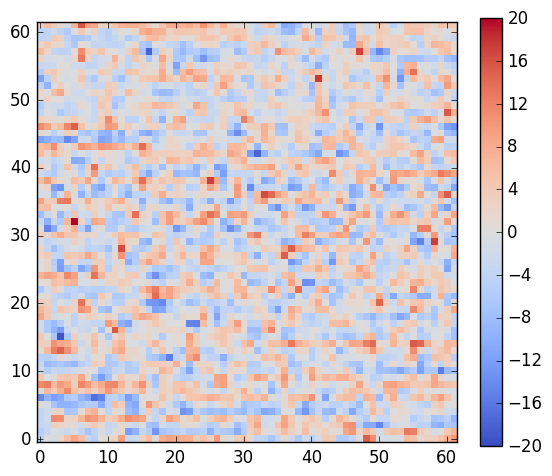

PyObject <matplotlib.colorbar.Colorbar object at 0x7f7411194da0>

In [90]:
ion()
figure(figsize=(6,6))
exsaturado=DatosCentrados["Trancazo_1"][:,:,340]+DatosCentrados["Trancazo_3"][:,:,340]+DatosCentrados["Trancazo_2"][:,:,340]
imagen=imshow(CSDexample, origin="lower", interpolation="nearest", cmap="coolwarm", vmin=-20, vmax=20)
cb=colorbar(imagen,fraction=0.046)
#savefig("LFP_Saturado_1-340.svg", dpi=96)

In [110]:
PyPlot.ioff()
for t=1:501
    datos=CSDPlanchada["Trancazo_1"][:,:,t];
    figure(figsize=(6,6))
    imagen=imshow(datos, origin="lower", interpolation="nearest", vmin=-20,vmax=20, cmap="coolwarm")
    cb=colorbar(imagen, fraction=0.046)
    savefig("CSD_1-$t.png", dpi=96)
    close()
end

In [111]:
using JLD
save("CSDEvocada.jld", "CSD", CSDPlanchada)

(-66,48)